# Autocorrelations

## Imports

In [1]:
import os
import sys
import time
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1


module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)

%autoreload 2
%matplotlib notebook

from l2hmc_eager import gauge_dynamics_eager as gde

Using TensorFlow backend.


In [3]:
from lattice.gauge_lattice import GaugeLattice

In [4]:
tf.enable_eager_execution()
tfe = tf.contrib.eager

from u1_model_eager import GaugeModelEager, train_one_iter
from gauge_model import GaugeModel

import utils.gauge_model_helpers as helpers

In [5]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    result /= result[result.argmax()]
    return result[result.size//2:]

In [6]:
def plot_broken_xaxis(xdata, ydata, xlabel, ylabel, output_file=None,
                      xlim1=(-2, 100), xlim2=(398,  500)):
    fig, (ax, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w')
    # plot the same data on both axes
    for idx in range(ydata.shape[1]):
        _ = ax.plot(xdata, ydata[:, idx], marker='', ls='-', 
                    alpha=0.7, lw=1.5, label=f'sample {idx}')

    _ = ax.plot(xdata, ydata.mean(axis=1), marker='', ls='-', 
                color='k', lw=2., label='average')

    for idx in range(ydata.shape[1]):
        _ = ax2.plot(xdata, ydata[:, idx], marker='', ls='-', 
                     alpha=0.7, lw=1.5, label=f'sample {idx}')

    _ = ax2.plot(xdata, ydata.mean(axis=1), marker='', ls='-', 
                 color='k', lw=2., label='average')

    # zoom-in / limit the view to different portions of the data
    _ = ax.set_xlim(xlim1)
    _ = ax2.set_xlim(xlim2)

    # hide the spines between ax and ax2
    _ = ax.spines['right'].set_visible(False)
    _ = ax2.spines['left'].set_visible(False)
    _ = ax.yaxis.tick_left()
    _ = ax.tick_params(labelright=False)
    _ = ax2.yaxis.tick_right()

    d = .015 # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    _ = ax.plot((1-d,1+d), (-d,+d), **kwargs)
    _ = ax.plot((1-d,1+d),(1-d,1+d), **kwargs)

    _ = kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    _ = ax2.plot((-d,+d), (1-d,1+d), **kwargs)
    _ = ax2.plot((-d,+d), (-d,+d), **kwargs)

    _ = ax.set_ylabel(ylabel, fontsize=14)
    label = ax.set_xlabel(xlabel, fontsize=14)
    _ = ax.xaxis.set_label_coords(1.1, -0.065)
    _ = ax2.legend(loc='best', fontsize=10)

    _ = plt.show()
    if output_file is not None:
        fig.savefig(output_file, dpi=400, bbox_inches='tight')
    return fig, ax, ax2

## Specify run directory containing parameters and samples 

In [22]:
log_dir = '../../gauge_logs_graph/run_37/'
info_dir = os.path.join(log_dir, 'run_info')
figs_dir = os.path.join(log_dir, 'figures')
params_file = os.path.join(info_dir, 'parameters.pkl')
with open(params_file, 'rb') as f:
    params = pickle.load(f)

In [23]:
# Create lattice with same parameters to use for calculating observables
lattice = GaugeLattice(params['time_size'],
                       params['space_size'],
                       params['dim'],
                       params['beta'],
                       params['link_type'],
                       params['num_samples'],
                       params['rand'])

In [24]:
# Load samples from `info_dir/samples_history.pkl` file
# Note that samples_history will be an array of shape:
#    [num_samples, num_eval_steps]
# where num_samples is the number of samples in each batch
# and num_eval steps is the number of steps the (trained) L2HMC simulation 
# was ran for.
samples_history_file = os.path.join(info_dir, 'samples_history.pkl')
with open(samples_history_file, 'rb') as f:
    samples_history = pickle.load(f)

In [25]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

step: 0  time / step: 0.3133  avg action:  1039   avg plaquette: 0.4928 top charge: -0.1513
step: 1  time / step: 0.4422  avg action: 732.5   avg plaquette: 0.6423 top charge: 0.1456
step: 2  time / step: 0.4661  avg action: 603.6   avg plaquette: 0.7053 top charge: -0.07655
step: 3  time / step: 0.4275  avg action: 524.4   avg plaquette: 0.7439 top charge: 0.1218
step: 4  time / step: 0.568   avg action: 470.9   avg plaquette: 0.7701 top charge: -0.08513
step: 5  time / step: 0.3956  avg action:  431    avg plaquette: 0.7895 top charge: 0.07014
step: 6  time / step: 0.4171  avg action: 404.7   avg plaquette: 0.8024 top charge: -0.04662
step: 7  time / step: 0.2504  avg action:  393    avg plaquette: 0.8081 top charge: 0.08087
step: 8  time / step: 0.4514  avg action: 375.8   avg plaquette: 0.8165 top charge: -0.04129
step: 9  time / step: 0.3611  avg action: 356.6   avg plaquette: 0.8259 top charge: 0.08223
step: 10  time / step: 0.2514  avg action: 341.7   avg plaquette: 0.8332 top c

step: 88  time / step: 0.2438  avg action: 168.9   avg plaquette: 0.9175 top charge: 0.03906
step: 89  time / step: 0.2104  avg action: 171.3   avg plaquette: 0.9164 top charge: 0.01127
step: 90  time / step: 0.2063  avg action: 165.5   avg plaquette: 0.9192 top charge: 0.02472
step: 91  time / step: 0.2029  avg action: 174.6   avg plaquette: 0.9147 top charge: -0.02029
step: 92  time / step: 0.2063  avg action: 168.9   avg plaquette: 0.9175 top charge: 0.02262
step: 93  time / step: 0.2737  avg action: 165.5   avg plaquette: 0.9192 top charge: 0.02096
step: 94  time / step: 0.1932  avg action:  163    avg plaquette: 0.9204 top charge: -0.008473
step: 95  time / step: 0.1981  avg action: 159.8   avg plaquette: 0.922  top charge: 0.01245
step: 96  time / step: 0.1892  avg action: 167.3   avg plaquette: 0.9183 top charge: 0.04238
step: 97  time / step: 0.3144  avg action: 167.7   avg plaquette: 0.9181 top charge: 0.00392
step: 98  time / step: 0.231   avg action: 174.4   avg plaquette: 0

step: 175  time / step: 0.2017  avg action: 151.8   avg plaquette: 0.9259 top charge: 0.01003
step: 176  time / step: 0.2345  avg action: 151.5   avg plaquette: 0.926  top charge: -0.03087
step: 177  time / step: 0.1963  avg action: 155.9   avg plaquette: 0.9239 top charge: 0.009889
step: 178  time / step: 0.1933  avg action: 154.7   avg plaquette: 0.9245 top charge: 0.02944
step: 179  time / step: 0.1896  avg action: 153.5   avg plaquette: 0.9251 top charge: 0.001992
step: 180  time / step: 0.1917  avg action: 151.2   avg plaquette: 0.9262 top charge: -0.008702
step: 181  time / step: 0.2349  avg action: 146.4   avg plaquette: 0.9285 top charge: 0.07059
step: 182  time / step: 0.2138  avg action: 148.2   avg plaquette: 0.9277 top charge: 0.0162
step: 183  time / step: 0.1955  avg action: 150.3   avg plaquette: 0.9266 top charge: 0.05685
step: 184  time / step: 0.206   avg action: 154.4   avg plaquette: 0.9246 top charge: 0.01343
step: 185  time / step: 0.2345  avg action: 150.9   avg 

step: 262  time / step: 0.3128  avg action: 138.2   avg plaquette: 0.9325 top charge: -0.02047
step: 263  time / step: 0.1978  avg action: 139.2   avg plaquette: 0.9321 top charge: 0.07713
step: 264  time / step: 0.2278  avg action: 139.3   avg plaquette: 0.932  top charge: 0.06322
step: 265  time / step: 0.2237  avg action: 139.4   avg plaquette: 0.9319 top charge: -0.0227
step: 266  time / step: 0.2434  avg action: 141.4   avg plaquette: 0.9309 top charge: 0.03894
step: 267  time / step: 0.2288  avg action: 140.6   avg plaquette: 0.9313 top charge: -0.03516
step: 268  time / step: 0.2155  avg action:  141    avg plaquette: 0.9312 top charge: 0.05814
step: 269  time / step: 0.2231  avg action: 146.3   avg plaquette: 0.9286 top charge: -0.0508
step: 270  time / step: 0.2282  avg action: 147.5   avg plaquette: 0.928  top charge: 0.03868
step: 271  time / step: 0.2425  avg action: 141.1   avg plaquette: 0.9311 top charge: -0.02744
step: 272  time / step: 0.2181  avg action: 146.4   avg p

step: 349  time / step: 0.225   avg action: 149.5   avg plaquette: 0.927  top charge: -0.002087
step: 350  time / step: 0.2129  avg action: 141.4   avg plaquette: 0.9309 top charge: 0.03984
step: 351  time / step: 0.2095  avg action: 143.6   avg plaquette: 0.9299 top charge: -0.004071
step: 352  time / step: 0.2193  avg action: 148.9   avg plaquette: 0.9273 top charge: 0.0169
step: 353  time / step: 0.1929  avg action: 151.2   avg plaquette: 0.9262 top charge: -0.007639
step: 354  time / step: 0.1883  avg action: 148.8   avg plaquette: 0.9274 top charge: 0.0008549
step: 355  time / step: 0.2288  avg action: 141.2   avg plaquette: 0.931  top charge: -0.00349
step: 356  time / step: 0.2213  avg action: 141.7   avg plaquette: 0.9308 top charge: -0.02562
step: 357  time / step: 0.2093  avg action: 141.8   avg plaquette: 0.9308 top charge: 0.000128
step: 358  time / step: 0.198   avg action: 144.8   avg plaquette: 0.9293 top charge: 0.05473
step: 359  time / step: 0.199   avg action: 139.2 

step: 436  time / step: 0.2046  avg action: 150.6   avg plaquette: 0.9265 top charge: 0.00957
step: 437  time / step: 0.2048  avg action:  150    avg plaquette: 0.9268 top charge: 0.0314
step: 438  time / step: 0.2386  avg action: 148.7   avg plaquette: 0.9274 top charge: -0.01619
step: 439  time / step: 0.2855  avg action: 150.8   avg plaquette: 0.9264 top charge: -0.01659
step: 440  time / step: 0.2174  avg action: 148.5   avg plaquette: 0.9275 top charge: 0.04019
step: 441  time / step: 0.2116  avg action:  149    avg plaquette: 0.9273 top charge: -0.01573
step: 442  time / step: 0.2211  avg action: 153.6   avg plaquette: 0.925  top charge: 0.01334
step: 443  time / step: 0.2238  avg action: 148.7   avg plaquette: 0.9274 top charge: -0.002758
step: 444  time / step: 0.2023  avg action: 147.5   avg plaquette: 0.928  top charge: -0.01054
step: 445  time / step: 0.2091  avg action: 148.3   avg plaquette: 0.9276 top charge: -0.01253
step: 446  time / step: 0.2089  avg action: 149.7   av

In [26]:
actions_history = np.array(actions_history)
avg_plaquettes_history = np.array(avg_plaquettes_history)
top_charges_history = np.array(top_charges_history)
steps = np.arange(len(actions_history))

In [27]:
# Compute the autocorrelation function using the topological charges
top_charges_autocorr_arr = []
num_samples = top_charges_history.shape[1]
for i in range(num_samples):
    top_charges_autocorr_arr.append(autocorr(top_charges_history[:, i]))
top_charges_autocorr_arr = np.array(top_charges_autocorr_arr)
top_charges_autocorr_avg = np.mean(top_charges_autocorr_arr, axis=0)

<IPython.core.display.Javascript object>


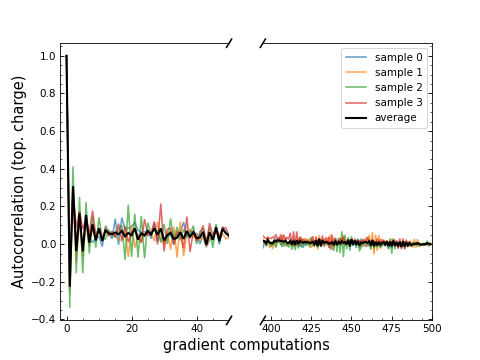

In [28]:
out_file = os.path.join(figs_dir, 'topological_charge_autocorr_fn.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_autocorr_arr.T,
                                 xlabel='gradient computations',
                                 ylabel='Autocorrelation (top. charge)',
                                 xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=out_file)

<IPython.core.display.Javascript object>


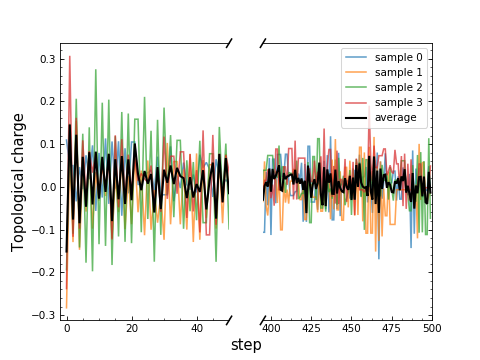

In [29]:
out_file = os.path.join(figs_dir, 'topological_charge_vs_step.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, top_charges_history,
                                 xlabel='step', ylabel='Topological charge',
                                 xlim1=(-2, 50), xlim2=(395, 500),
                                 output_file=None)
ax2.legend(loc='upper right')
plt.savefig(out_file, dpi=400, bbox_inches='tight')

In [30]:
from lattice.gauge_lattice import u1_plaq_exact

<IPython.core.display.Javascript object>


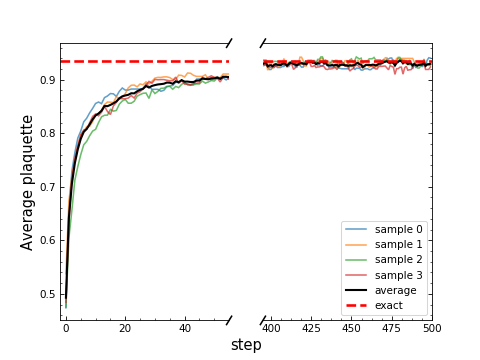

In [31]:
out_file = os.path.join(figs_dir, 'average_plaquette_vs_step.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, avg_plaquettes_history,
                                 xlabel='step', ylabel='Average plaquette',
                                 xlim1=(-2, 55), xlim2=(395, 500),
                                 output_file=None)

_ = ax.axhline(y=u1_plaq_exact(params['beta']), 
           color='r', ls='--', lw=2.5, label='exact')

_ = ax2.axhline(y=u1_plaq_exact(params['beta']), 
                color='r', ls='--', lw=2.5, label='exact')
leg = ax2.legend(loc='lower right', fontsize=10)

plt.savefig(out_file, dpi=400, bbox_inches='tight')

<IPython.core.display.Javascript object>


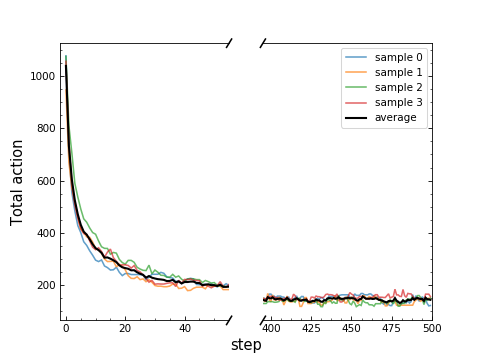

In [32]:
out_file = os.path.join(figs_dir, 'average_action_vs_step.pdf')
fig, ax, ax2 = plot_broken_xaxis(steps, actions_history,
                                 xlabel='step', ylabel='Total action',
                                 xlim1=(-2, 55), xlim2=(395, 500),
                                 output_file=out_file)

In [92]:
tf.InteractiveSession.close

<function tensorflow.python.client.session.InteractiveSession.close(self)>

In [105]:
tf.Session().close()

In [90]:
#sess = tf.InteractiveSession()

/Users/saforem2/Library/Python/3.6/lib/python/site-packages/tensorflow/python/client/session.py:1662: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [106]:
tf.reset_default_graph()

In [107]:
lattice = GaugeLattice(8, 8, 2, 8., 'U1', 2, rand=False)

In [108]:
samples = tf.convert_to_tensor(lattice.samples, dtype=tf.float32)
potential_fn = lattice.get_energy_function(samples)

In [109]:
dynamics = gde.GaugeDynamicsEager(
    lattice=lattice,
    num_steps=5,
    eps=0.1,
    minus_loglikelihood_fn=potential_fn,
    conv_net=True,
    hmc=False,
    eps_trainable=True
)

In [110]:
# Define training and validation datasets with the same structure.
training_dataset = tf.data.Dataset.range(100).map(
    lambda x: x + tf.random_uniform([], -10, 10, tf.int64))
validation_dataset = tf.data.Dataset.range(50)

In [111]:
# A reinitializable iterator is defined by its structure. We could use the
# `output_types` and `output_shapes` properties of either `training_dataset`
# or `validation_dataset` here, because they are compatible.
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_element = iterator.get_next()

In [112]:
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

In [113]:
# Run 20 epochs in which the training dataset is traversed, followed by the
# validation dataset.
for _ in range(20):
  # Initialize an iterator over the training dataset.
  sess.run(training_init_op)
  for _ in range(10):
    sess.run(next_element)

  # Initialize an iterator over the validation dataset.
  sess.run(validation_init_op)
  for _ in range(5):
    sess.run(next_element)

ValueError: Fetch argument <tf.Operation 'make_initializer' type=MakeIterator> cannot be interpreted as a Tensor. (Operation name: "make_initializer"
op: "MakeIterator"
input: "MapDataset"
input: "IteratorV2"
device: "/device:CPU:0"
attr {
  key: "_class"
  value {
    list {
      s: "loc:@IteratorV2"
    }
  }
}
 is not an element of this graph.)

In [ ]:
dataset = tf.data.Dataset.range(5)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

sess.run(iterator.initializer)
print(sess.run(result))  # ==> "0"
print(sess.run(result))  # ==> "2"
print(sess.run(result))  # ==> "4"
print(sess.run(result))  # ==> "6"
print(sess.run(result))  # ==> "8"
try:
  sess.run(result)
except tf.errors.OutOfRangeError:
  print("End of dataset")  # ==> "End of dataset"

In [99]:
samples_placeholder = tf.placeholder(samples.dtype, samples.shape)

In [100]:
dataset = tf.data.Dataset.from_tensor_slices(samples_placeholder).batch(2)

In [102]:
dataset.output_shapes

TensorShape([Dimension(None), Dimension(8), Dimension(8), Dimension(2)])

In [104]:
dataset = tf.data.Dataset.from_tensor_slices(dynamics.apply_transition(samples_placeholder))

In [103]:
dataset.apply(dynamics.apply_transition)

TypeError: Failed to convert object of type <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'> to Tensor. Contents: <BatchDataset shapes: (?, 8, 8, 2), types: tf.float32>. Consider casting elements to a supported type.

In [85]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

In [76]:
sess.run(iterator.initializer, feed_dict={samples_placeholder: samples})

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(2, 8, 8, 2), dtype=float32) is not an element of this graph.

In [ ]:
max_value = tf.placeholder(tf.int64, shape=[])
dataset = tf.data.Dataset.range(max_value)    # Take a placeholder to create a dataset
iterator = dataset.make_initializable_iterator()      # Create an initializable iterator
next_element = iterator.get_next()

with tf.Session() as sess:
    # Initialize an iterator over a dataset with 10 elements using placeholder.
    sess.run(iterator.initializer, feed_dict={max_value: 10}) 

    for i in range(10):
        value = sess.run(next_element)
        print(f"{value} ", end=" ")    # 0 1 2 3 ... 9

In [51]:
dataset = tf.data.Dataset.from_tensors(samples_placeholder)

In [52]:
dataset

<TensorDataset shapes: (2, 8, 8, 2), types: tf.float32>

In [41]:
dataset.apply(dynamics.apply_transition)
dataset = dataset.map(dynamics.apply_transition)

TypeError: Failed to convert object of type <class 'tensorflow.python.data.ops.dataset_ops.TensorDataset'> to Tensor. Contents: <TensorDataset shapes: (2, 8, 8, 2), types: tf.float32>. Consider casting elements to a supported type.

In [53]:
iterator = dataset.make_initializable_iterator()

In [54]:
sess.run(iterator.initializer, 
         feed_dict={samples_placeholder: lattice.samples})

TypeError: Cannot interpret feed_dict key as Tensor: Tensor Tensor("Placeholder:0", shape=(2, 8, 8, 2), dtype=float32) is not an element of this graph.

In [55]:
next_element = iterator.get_next()

In [56]:
result = dynamics.apply_transition(next_element)

In [66]:
result.index(0)

ValueError: tuple.index(x): x not in tuple

In [58]:
sess.run(result)

ValueError: Fetch argument <tf.Tensor 'add_6260:0' shape=(2, 8, 8, 2) dtype=float32> cannot be interpreted as a Tensor. (Tensor Tensor("add_6260:0", shape=(2, 8, 8, 2), dtype=float32) is not an element of this graph.)

In [ ]:
result = dynamics.apply_transition(next_element)

In [ ]:
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()

# Typically `result` will be the output of a model, or an optimizer's
# training operation.
result = tf.add(next_element, next_element)

In [ ]:
features_placeholder = tf.placeholder(features.dtype, features.shape)
labels_placeholder = tf.placeholder(labels.dtype, labels.shape)

dataset = tf.data.Dataset.from_tensor_slices((features_placeholder, labels_placeholder))
# [Other transformations on `dataset`...]
dataset = ...
iterator = dataset.make_initializable_iterator()

sess.run(iterator.initializer, feed_dict={features_placeholder: features,
                                          labels_placeholder: labels})

In [67]:
help(tf.data.Dataset.from_tensors)

Help on function from_tensors in module tensorflow.python.data.ops.dataset_ops:

from_tensors(tensors)
    Creates a `Dataset` with a single element, comprising the given tensors.
    
    Note that if `tensors` contains a NumPy array, and eager execution is not
    enabled, the values will be embedded in the graph as one or more
    `tf.constant` operations. For large datasets (> 1 GB), this can waste
    memory and run into byte limits of graph serialization.  If tensors contains
    one or more large NumPy arrays, consider the alternative described in
    [this guide](https://tensorflow.org/guide/datasets#consuming_numpy_arrays).
    
    Args:
      tensors: A nested structure of tensors.
    
    Returns:
      Dataset: A `Dataset`.



In [ ]:
dataset = 